In [12]:
!pip install timm

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import timm
from sklearn.metrics import accuracy_score
import os

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 32
learning_rate = 1e-4
num_epochs = 20
img_size = 224  # Standard for ViT

In [15]:
# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/kaggle/input/accident-detection-from-cctv-footage/data'  # Update with your dataset path
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Load a pretrained Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler('cuda')  # Updated for compatibility

In [18]:
def train(model, loader, criterion, optimizer, scaler):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

In [20]:
from tqdm import tqdm
import time

best_val_acc = 0.0
early_stopping_counter = 0
patience = 5  # Stop training if no improvement for 5 epochs

for epoch in range(num_epochs):
    start_time = time.time()

    # Training Phase
    model.train()
    train_loss, train_correct = 0, 0
    total_samples = 0

    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += images.size(0)

            pbar.set_postfix({'Loss': loss.item()})

    train_loss /= total_samples
    train_acc = train_correct / total_samples

    # Validation Phase
    model.eval()
    val_loss, val_correct = 0, 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += images.size(0)

    val_loss /= total_samples
    val_acc = val_correct / total_samples

    # Learning rate adjustment
    scheduler.step()

    # Logging
    end_time = time.time()
    epoch_time = end_time - start_time
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f}s")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
        early_stopping_counter = 0  # Reset counter if accuracy improves
        print("Model improved. Saved new best model.")
    else:
        early_stopping_counter += 1

    # Early Stopping
    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

Training Epoch 1/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.648]


Epoch 1/20 | Train Loss: 0.7138 | Train Acc: 0.5183 | Val Loss: 0.8261 | Val Acc: 0.4694 | LR: 0.000095 | Time: 30.16s
Model improved. Saved new best model.


Training Epoch 2/20: 100%|██████████| 25/25 [00:28<00:00,  1.12s/it, Loss=0.628]


Epoch 2/20 | Train Loss: 0.6934 | Train Acc: 0.5588 | Val Loss: 0.7274 | Val Acc: 0.4694 | LR: 0.000090 | Time: 30.34s


Training Epoch 3/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.679]


Epoch 3/20 | Train Loss: 0.6915 | Train Acc: 0.5626 | Val Loss: 0.6832 | Val Acc: 0.4898 | LR: 0.000085 | Time: 30.20s
Model improved. Saved new best model.


Training Epoch 4/20: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it, Loss=0.453]


Epoch 4/20 | Train Loss: 0.6534 | Train Acc: 0.6283 | Val Loss: 0.8376 | Val Acc: 0.5408 | LR: 0.000079 | Time: 30.29s
Model improved. Saved new best model.


Training Epoch 5/20: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it, Loss=0.665]


Epoch 5/20 | Train Loss: 0.7072 | Train Acc: 0.5601 | Val Loss: 0.6330 | Val Acc: 0.6531 | LR: 0.000073 | Time: 30.34s
Model improved. Saved new best model.


Training Epoch 6/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.556]


Epoch 6/20 | Train Loss: 0.6380 | Train Acc: 0.6448 | Val Loss: 0.6319 | Val Acc: 0.6735 | LR: 0.000065 | Time: 30.06s
Model improved. Saved new best model.


Training Epoch 7/20: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it, Loss=0.599]


Epoch 7/20 | Train Loss: 0.6266 | Train Acc: 0.6498 | Val Loss: 0.6471 | Val Acc: 0.6531 | LR: 0.000058 | Time: 30.20s


Training Epoch 8/20: 100%|██████████| 25/25 [00:27<00:00,  1.10s/it, Loss=0.676]


Epoch 8/20 | Train Loss: 0.6359 | Train Acc: 0.6359 | Val Loss: 0.6227 | Val Acc: 0.6531 | LR: 0.000050 | Time: 29.80s


Training Epoch 9/20: 100%|██████████| 25/25 [00:27<00:00,  1.10s/it, Loss=0.699]


Epoch 9/20 | Train Loss: 0.6259 | Train Acc: 0.6549 | Val Loss: 0.6068 | Val Acc: 0.6837 | LR: 0.000042 | Time: 29.91s
Model improved. Saved new best model.


Training Epoch 10/20: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it, Loss=0.57] 


Epoch 10/20 | Train Loss: 0.5902 | Train Acc: 0.6738 | Val Loss: 0.5586 | Val Acc: 0.7041 | LR: 0.000035 | Time: 30.23s
Model improved. Saved new best model.


Training Epoch 11/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.746]


Epoch 11/20 | Train Loss: 0.5786 | Train Acc: 0.7029 | Val Loss: 0.5090 | Val Acc: 0.7653 | LR: 0.000027 | Time: 30.12s
Model improved. Saved new best model.


Training Epoch 12/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.462]


Epoch 12/20 | Train Loss: 0.5190 | Train Acc: 0.7282 | Val Loss: 0.4705 | Val Acc: 0.8163 | LR: 0.000021 | Time: 30.09s
Model improved. Saved new best model.


Training Epoch 13/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.602]


Epoch 13/20 | Train Loss: 0.4839 | Train Acc: 0.7573 | Val Loss: 0.5062 | Val Acc: 0.7143 | LR: 0.000015 | Time: 30.08s


Training Epoch 14/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.505]


Epoch 14/20 | Train Loss: 0.4590 | Train Acc: 0.7838 | Val Loss: 0.4306 | Val Acc: 0.7959 | LR: 0.000010 | Time: 30.14s


Training Epoch 15/20: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it, Loss=0.51] 


Epoch 15/20 | Train Loss: 0.3816 | Train Acc: 0.8217 | Val Loss: 0.3446 | Val Acc: 0.8265 | LR: 0.000005 | Time: 30.87s
Model improved. Saved new best model.


Training Epoch 16/20: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it, Loss=0.229]


Epoch 16/20 | Train Loss: 0.3537 | Train Acc: 0.8319 | Val Loss: 0.2972 | Val Acc: 0.8469 | LR: 0.000002 | Time: 30.82s
Model improved. Saved new best model.


Training Epoch 17/20: 100%|██████████| 25/25 [00:27<00:00,  1.10s/it, Loss=0.239]


Epoch 17/20 | Train Loss: 0.2930 | Train Acc: 0.8723 | Val Loss: 0.3031 | Val Acc: 0.8571 | LR: 0.000001 | Time: 29.90s
Model improved. Saved new best model.


Training Epoch 18/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.378]


Epoch 18/20 | Train Loss: 0.2612 | Train Acc: 0.8900 | Val Loss: 0.3200 | Val Acc: 0.8571 | LR: 0.000000 | Time: 30.35s


Training Epoch 19/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.312]


Epoch 19/20 | Train Loss: 0.2557 | Train Acc: 0.8925 | Val Loss: 0.3182 | Val Acc: 0.8673 | LR: 0.000001 | Time: 29.96s
Model improved. Saved new best model.


Training Epoch 20/20: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it, Loss=0.207] 


Epoch 20/20 | Train Loss: 0.2545 | Train Acc: 0.8989 | Val Loss: 0.3688 | Val Acc: 0.8367 | LR: 0.000002 | Time: 30.21s


<ipython-input-21-f90b829c6bb3>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))


              precision    recall  f1-score   support

    Accident       0.82      0.77      0.79        47
Non Accident       0.80      0.85      0.83        53

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



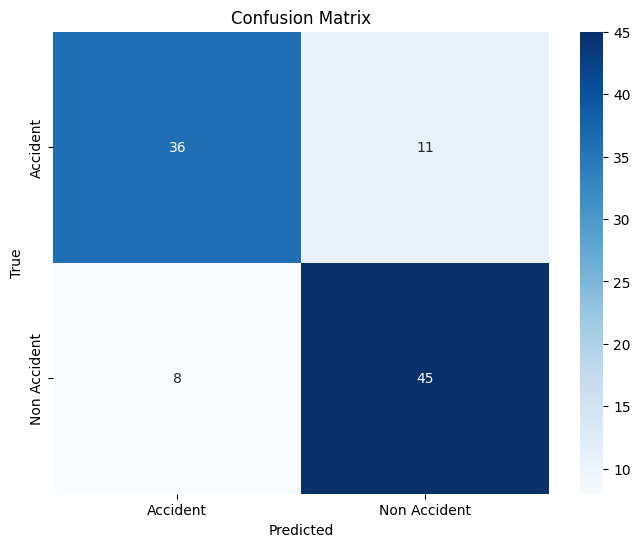

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
target_names = test_dataset.classes  # ['Accident', 'Non-Accident']
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 222MB/s]  
Training Epoch 1/25: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it, Loss=0.514]


Epoch 1/25 | Train Loss: 0.6671 | Train Acc: 0.6359 | Val Loss: 0.4717 | Val Acc: 0.7551 | LR: 0.000100 | Time: 27.76s
Model improved. Saved new best model.


Training Epoch 2/25: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s, Loss=0.0855]


Epoch 2/25 | Train Loss: 0.3597 | Train Acc: 0.8458 | Val Loss: 0.3103 | Val Acc: 0.8469 | LR: 0.000100 | Time: 26.48s
Model improved. Saved new best model.


Training Epoch 3/25: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s, Loss=0.203]


Epoch 3/25 | Train Loss: 0.2838 | Train Acc: 0.8850 | Val Loss: 0.2327 | Val Acc: 0.8980 | LR: 0.000100 | Time: 25.47s
Model improved. Saved new best model.


Training Epoch 4/25: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s, Loss=0.218] 


Epoch 4/25 | Train Loss: 0.1527 | Train Acc: 0.9418 | Val Loss: 0.4930 | Val Acc: 0.8163 | LR: 0.000100 | Time: 25.53s


Training Epoch 5/25: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s, Loss=0.106] 


Epoch 5/25 | Train Loss: 0.1506 | Train Acc: 0.9469 | Val Loss: 0.3596 | Val Acc: 0.8673 | LR: 0.000100 | Time: 25.35s


Training Epoch 6/25: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s, Loss=0.193]  


Epoch 6/25 | Train Loss: 0.0829 | Train Acc: 0.9735 | Val Loss: 0.3196 | Val Acc: 0.9082 | LR: 0.000100 | Time: 25.68s
Model improved. Saved new best model.


Training Epoch 7/25: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s, Loss=0.153]  


Epoch 7/25 | Train Loss: 0.0908 | Train Acc: 0.9747 | Val Loss: 0.3228 | Val Acc: 0.9082 | LR: 0.000010 | Time: 25.54s


Training Epoch 8/25: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s, Loss=0.0202] 


Epoch 8/25 | Train Loss: 0.0512 | Train Acc: 0.9810 | Val Loss: 0.2481 | Val Acc: 0.9082 | LR: 0.000010 | Time: 25.50s


Training Epoch 9/25: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s, Loss=0.0113] 


Epoch 9/25 | Train Loss: 0.0235 | Train Acc: 0.9924 | Val Loss: 0.2561 | Val Acc: 0.9082 | LR: 0.000010 | Time: 26.52s


Training Epoch 10/25: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s, Loss=0.00782]


Epoch 10/25 | Train Loss: 0.0167 | Train Acc: 0.9937 | Val Loss: 0.2690 | Val Acc: 0.9286 | LR: 0.000010 | Time: 25.59s
Model improved. Saved new best model.


Training Epoch 11/25: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s, Loss=0.00436]


Epoch 11/25 | Train Loss: 0.0144 | Train Acc: 0.9924 | Val Loss: 0.2754 | Val Acc: 0.9184 | LR: 0.000010 | Time: 25.94s


Training Epoch 12/25: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s, Loss=0.00272]


Epoch 12/25 | Train Loss: 0.0131 | Train Acc: 0.9924 | Val Loss: 0.2839 | Val Acc: 0.9082 | LR: 0.000010 | Time: 25.31s


Training Epoch 13/25: 100%|██████████| 25/25 [00:23<00:00,  1.04it/s, Loss=0.00265] 


Epoch 13/25 | Train Loss: 0.0123 | Train Acc: 0.9949 | Val Loss: 0.2868 | Val Acc: 0.9286 | LR: 0.000010 | Time: 25.70s


Training Epoch 14/25: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s, Loss=0.0012] 


Epoch 14/25 | Train Loss: 0.0115 | Train Acc: 0.9924 | Val Loss: 0.2954 | Val Acc: 0.9082 | LR: 0.000001 | Time: 25.46s


Training Epoch 15/25: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s, Loss=0.00188]


Epoch 15/25 | Train Loss: 0.0102 | Train Acc: 0.9949 | Val Loss: 0.2959 | Val Acc: 0.9082 | LR: 0.000001 | Time: 25.67s
Early stopping triggered.


<ipython-input-23-f48088cf5995>:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))


              precision    recall  f1-score   support

    Accident       0.94      0.98      0.96        47
Non Accident       0.98      0.94      0.96        53

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



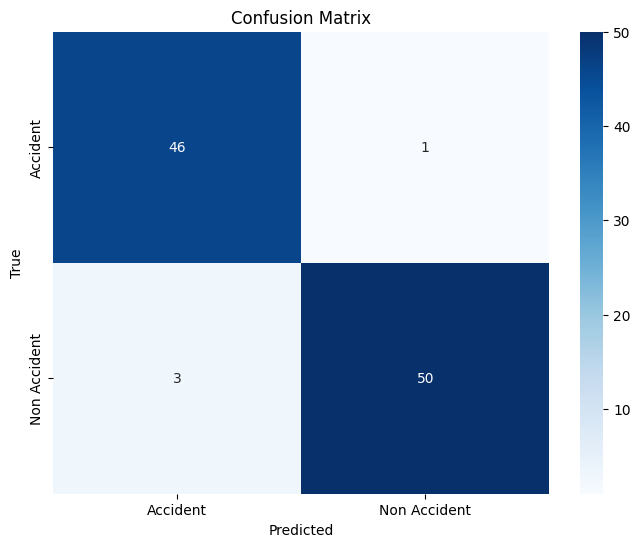

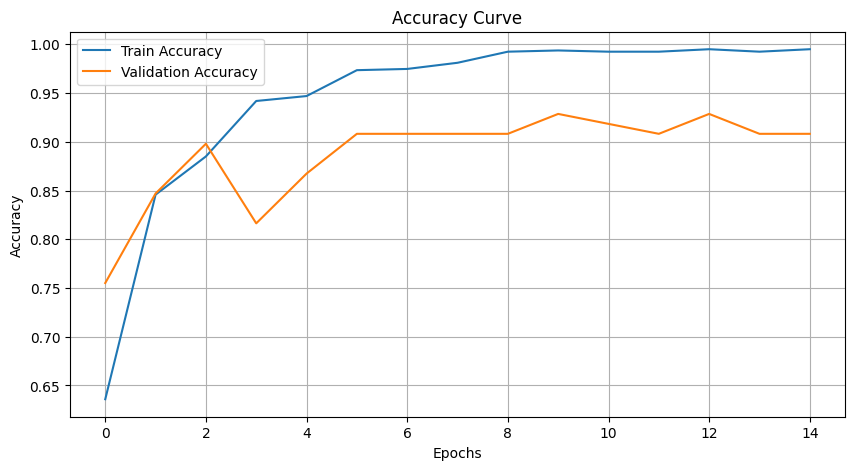

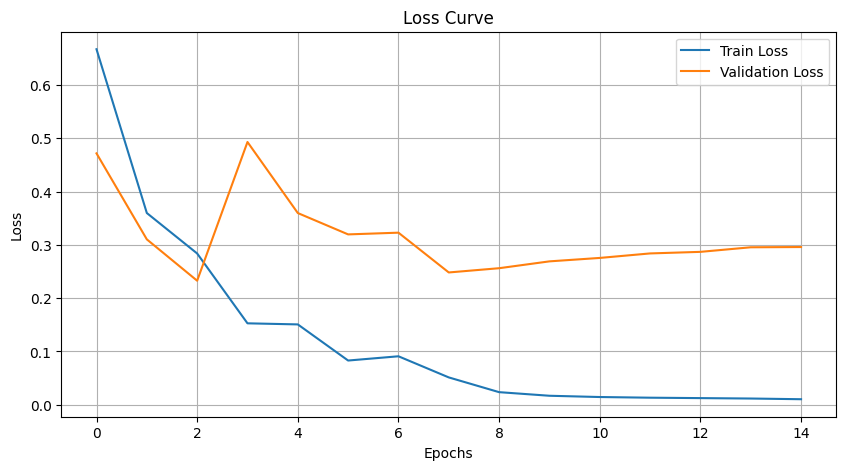

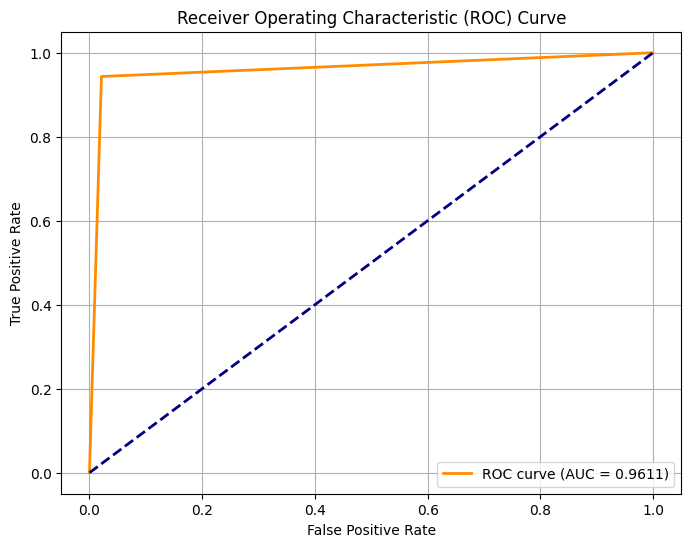

In [23]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# Check Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 25
batch_size = 32
learning_rate = 1e-4
patience = 5  # Early stopping patience

# Data Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Dataset
train_dataset = datasets.ImageFolder(root='/kaggle/input/accident-detection-from-cctv-footage/data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/accident-detection-from-cctv-footage/data/val', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/accident-detection-from-cctv-footage/data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Vision Transformer Model
from torchvision.models import vit_b_16

model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, len(train_dataset.classes))
model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scaler = torch.amp.GradScaler('cuda')

# Training Metrics History
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

# Training Loop
best_val_acc = 0.0
early_stopping_counter = 0

for epoch in range(num_epochs):
    start_time = time.time()

    # Training Phase
    model.train()
    train_loss, train_correct, total_samples = 0, 0, 0

    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += images.size(0)

            pbar.set_postfix({'Loss': loss.item()})

    train_loss /= total_samples
    train_acc = train_correct / total_samples
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Validation Phase
    model.eval()
    val_loss, val_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += images.size(0)

    val_loss /= total_samples
    val_acc = val_correct / total_samples
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    # Learning Rate Adjustment
    scheduler.step()

    # Logging
    end_time = time.time()
    epoch_time = end_time - start_time
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.2f}s")

    # Save the Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
        early_stopping_counter = 0
        print("Model improved. Saved new best model.")
    else:
        early_stopping_counter += 1

    # Early Stopping
    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Load Best Model for Evaluation
model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report and Confusion Matrix
target_names = test_dataset.classes
print(classification_report(all_labels, all_preds, target_names=target_names))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve and AUC
all_labels_bin = label_binarize(all_labels, classes=[0, 1])
all_preds_bin = label_binarize(all_preds, classes=[0, 1])

fpr, tpr, _ = roc_curve(all_labels_bin, all_preds_bin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()